# Search engines for images through a REST API


This example starts a [waitress](https://github.com/Pylons/waitress) server, creates a [WSGI](https://en.wikipedia.org/wiki/Web_Server_Gateway_Interface) application based on [falcon](https://falconframework.org/) and queries the REST API. This application takes an image and searches for similar images based on features produced by a deep learning model.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Settings

In [3]:
host = '127.0.0.1'
port = 8085

Creates the search engine and starts a server in a different process.
See [search_images_dogcat](http://www.xavierdupre.fr/app/ensae_projects/helpsphinx/ensae_projects/restapi/search_images_dogcat.html?highlight=search_images_dogcat#module-ensae_projects.restapi.search_images_dogcat).

In [4]:
code = """
def process_server_images(host, port):
    # Enable the section to intercept logged information.
    import logging
    logging.basicConfig(level=logging.DEBUG)
    logger = logging.getLogger('search_images_dogcat')
    logger.setLevel(logging.INFO)
    hdlr = logging.FileHandler('search_images_dogcat.log')
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr)

    url = None
    # If not specified, the application looks for zip file:
    # http://www.xavierdupre.fr/enseignement/complements/dog-cat-pixabay.zip
    from ensae_projects.restapi import search_images_dogcat
    app = search_images_dogcat(url_images=url, module="torch")

    from waitress import serve
    print("Start")
    serve(app, host=host, port=port)

print("Begin")
"""

Saves this code into a file and adds additional paths.

In [5]:
import os
import ensae_projects

def path_module(mod):
    m = __import__(mod)
    return os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(m.__file__), '..')))


code = code + "\nprocess_server_images('{0}', {1})\n".format(host, port)
dest = os.path.abspath('temp_scripts')
if not os.path.exists(dest):
    os.mkdir(dest)
code_file = os.path.join(dest, "_start_server.py")
print("Write file '{0}'.".format(code_file))
with open(code_file, "w") as f:
    f.write(code)

print('# final code to run')
print(code)

Write file 'C:\xavierdupre\__home_\GitHub\ensae_projects\_doc\notebooks\api_rest\temp_scripts\_start_server.py'.
# final code to run

def process_server_images(host, port):
    # Enable the section to intercept logged information.
    import logging
    logging.basicConfig(level=logging.DEBUG)
    logger = logging.getLogger('search_images_dogcat')
    logger.setLevel(logging.INFO)
    hdlr = logging.FileHandler('search_images_dogcat.log')
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr)

    url = None
    # If not specified, the application looks for zip file:
    # http://www.xavierdupre.fr/enseignement/complements/dog-cat-pixabay.zip
    from ensae_projects.restapi import search_images_dogcat
    app = search_images_dogcat(url_images=url, module="torch")

    from waitress import serve
    print("Start")
    serve(app, host=host, port=port)

print("Begin")

process_server_images('127.0.0.1', 8085)

## Starts the server

In [6]:
import sys
from subprocess import Popen
if sys.platform.startswith('win'):
    cmd = '{0} -u "{1}"'.format(sys.executable.replace('w.exe', '.exe'),
                                code_file)
    print("Running '{0}'".format(cmd))
    proc = Popen(cmd)
else:
    cmd = [sys.executable, '-u', code_file]
    print("Running '{0}'".format(cmd))
    proc = Popen(cmd)
print('Start server, process id', proc.pid)

Running 'c:\python370_x64\python.exe -u "C:\xavierdupre\__home_\GitHub\ensae_projects\_doc\notebooks\api_rest\temp_scripts\_start_server.py"'
Start server, process id 15556


Let's wait.

In [7]:
from time import sleep
sleep(10)

## Let's load an image.

In [8]:
from lightmlrestapi.args import image2base64
import ensae_projects.datainc.search_images as si
imgfile = os.path.abspath(os.path.join(
    os.path.dirname(si.__file__), "cat-1192026__480.jpg"))
if not os.path.exists(imgfile):
    raise FileNotFoundError("Unable to find '{0}'".format(imgfile))

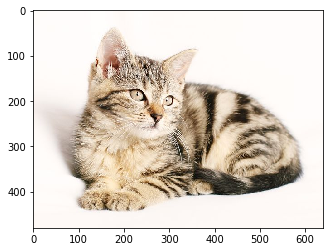

In [9]:
from PIL import Image
img = Image.open(imgfile)

import numpy
from matplotlib.pyplot import imshow
imshow(numpy.asarray(img));

## Let's query the server

The first query is quite long as it loads the model.

In [10]:
import requests
import ujson

b64 = image2base64(imgfile)[1]
features = ujson.dumps({'X': b64})
url_api = 'http://127.0.0.1:%d' % port
r = requests.post(url_api, data=features, timeout=15)
r

<Response [201]>

In [11]:
js = r if isinstance(r, dict) else r.json()
if 'description' in js:
    # This is an error.
    print("ERROR:", js['description'])
    res = None
else:
    res = []
    ans = js['Y']
    print("Number of neighbors:", len(ans))
    for n in ans:
        print("score, id", n[:2])
        shortname = n[2]['name'].replace("\\", "/").split('/')
        res.append((n[0], "/".join(shortname[-2:])))

Number of neighbors: 5
score, id [45.7871682992, 1]
score, id [66.0685246001, 11]
score, id [82.5819784952, 5]
score, id [83.3830068399, 28]
score, id [85.5619601811, 0]


In [12]:
%timeit requests.post(url_api, data=features, timeout=60)

107 ms ± 551 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's display the images.

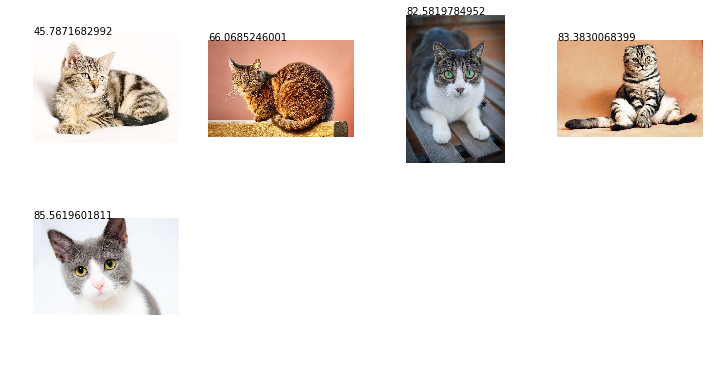

In [13]:
txts = list(map(lambda x: str(x[0]), res))
imgs = list(map(lambda x: os.path.join(
    'temp_scripts', 'images', x[1]), res))
if not os.path.exists(imgs[0]):
    imgs = list(map(lambda x: os.path.join(
        'images', x[1]), res))

from mlinsights.plotting import plot_gallery_images
try:
    plot_gallery_images(imgs, txts)
except FileNotFoundError as e:
    raise FileNotFoundError("Unable to find images '{0}' - cwd='{1}' full='{2}'".format(
        imgs[0], os.getcwd(), os.path.abspath(imgs[0])))

## Stop the server

In [14]:
from pyquickhelper.loghelper import reap_children
reap_children(subset={proc.pid}, fLOG=print)

process psutil.Process(pid=15556, status='terminated') terminated with exit code 15


{15556}